In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
%store -r time_window
%store -r lab_feature_space

TODO:
1. Cancel weighted voting
2. CI and p-vals
3. Sub-groups
4. Sensitivity analysis

In [2]:
len(lab_feature_space)

40

In [3]:
num_processors = multiprocessing.cpu_count()

In [4]:
dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset.csv")

In [5]:
#data overlap rate (entire dataset)
SCR_overlap = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap.npy')
LAB_overlap = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap.npy')

In [6]:
assert(SCR_overlap.shape[0] == LAB_overlap.shape[0])
assert(~np.isnan(SCR_overlap).any())
assert(~np.isnan(LAB_overlap).any())

In [7]:
# no need to shuffle again since we have done it.
%store -r train_len
%store -r test_len

data_train = dataset.iloc[:train_len, :].copy(deep = True)
data_test = dataset.iloc[train_len:, :].copy(deep = True)

In [8]:
print(len(data_train), len(data_test))

8637 8542


In [9]:
assert((len(data_train) + len(data_test)) == len(dataset))

In [10]:
# normalize the dataset by train and test
data_train = (data_train - data_train.min(skipna=True)) / \
(data_train.max(skipna=True) - data_train.min(skipna=True))

data_test = (data_test - data_test.min(skipna=True)) / \
(data_test.max(skipna=True) - data_test.min(skipna=True))

In [11]:
# consequently, we will only use the upper-left block of the overlap rate mtx for one-vs-all training
SCR_overlap_train = SCR_overlap[:len(data_train), :len(data_train)]
LAB_overlap_train = LAB_overlap[:len(data_train), :len(data_train)]

# Compute SCr Similarity 

Methods: DTW-AROW on raw, linear interpolation + Euclidean distance, cosine similarity, Manhattan

1. DTW-AROW

In [12]:
# to compute similarity mtx on SCR, we still need to compute the global
# SCR similarity mtx (so that we can use well-written functions)
# DTW-AROW
import sys
sys.path.append('/home/lideyi/AKI_SMART/SMART/DTW_with_missing_values')
import dtw_missing.dtw_missing as dtw_m
from Z_Helping_Functions import translate_dist_mtx_to_simi, fast_argsort, slow_argsort, min_max_normalization

In [13]:
# get SCR measurements for val(i.e. both train and dev)
SCR = dataset.loc[:, time_window]

In [14]:
def parallel_distance_matrix(df, num_processes, metric):
    pool = Pool(num_processes)
    total = len(df)

    results = list(tqdm(pool.imap(calculate_overlap, [(i, df, metric) for i in range(total - 1)]), total=total - 1))
    pool.close()
    pool.join()
    return create_distance_matrix(results)

In [15]:
def calculate_overlap(args):
    index, df, metric = args
    return [metric(df.iloc[index], df.iloc[j]) for j in range(index + 1, len(df))]

In [16]:
def create_distance_matrix(distance_list):
    n = len(distance_list[0]) + 1

    matrix = np.zeros((n, n))

    for i in range(n-1):
        matrix[i, i+1:i+1+len(distance_list[i])] = distance_list[i]

    for i in range(n):
        for j in range(i+1, n):
            matrix[j, i] = matrix[i, j]
    return matrix

In [17]:
def get_DTW_distance(u, v):
    u = np.array(u)
    v = np.array(v)
    d = dtw_m.warping_paths(u, v)[0]
    return d

In [18]:
# SCR_DTW_dist = parallel_distance_matrix(SCR, num_processors, get_DTW_distance)
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput2.npy', SCR_DTW_dist)

In [19]:
SCR_DTW_dist = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput2.npy')

In [20]:
# transfrom distance mtx to similarity score mtx by min-max normalization
SCR_DTW_simi = translate_dist_mtx_to_simi(SCR_DTW_dist)
# transform similarity score mtx to idx matrix by most similar rank highest
SCR_DTW_idx = fast_argsort(SCR_DTW_simi, num_processors)

In [21]:
# get the similarity matrix and idx rankings for train set
SCR_DTW_dist_train = SCR_DTW_dist[:len(data_train), :len(data_train)]
SCR_DTW_simi_train = translate_dist_mtx_to_simi(SCR_DTW_dist_train)
SCR_DTW_idx_train = fast_argsort(SCR_DTW_simi_train, num_processors)

In [22]:
assert(~np.isnan(SCR_DTW_simi).any())
assert(~np.isnan(SCR_DTW_idx).any())
assert(~np.isnan(SCR_DTW_simi_train).any())
assert(~np.isnan(SCR_DTW_idx_train).any())

2. Euclidean distance

In [23]:
# Euclidean distance and following methods do not support missing values.
# we need use interpolation to fill in missing values
SCR_ip = SCR.interpolate(method='linear', axis = 1)
SCR_ip = SCR_ip.fillna(method='bfill', axis = 1)
SCR_ip = SCR_ip.fillna(method='ffill', axis = 1)

/scratch/local/52186717/ipykernel_2697732/1056471520.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  SCR_ip = SCR_ip.fillna(method='bfill', axis = 1)
/scratch/local/52186717/ipykernel_2697732/1056471520.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  SCR_ip = SCR_ip.fillna(method='ffill', axis = 1)


In [24]:
SCR_train = SCR_ip.iloc[:train_len, :]
SCR_test = SCR_ip.iloc[train_len:, :]

In [25]:
from sklearn.metrics import pairwise_distances

In [26]:
SCR_Euc_dist = pairwise_distances(SCR_ip, metric='euclidean', n_jobs=-1)
SCR_Euc_simi = translate_dist_mtx_to_simi(SCR_Euc_dist)
SCR_Euc_idx = fast_argsort(SCR_Euc_simi, num_processors)

In [27]:
SCR_Euc_dist_train = SCR_Euc_dist[:len(data_train), :len(data_train)]
SCR_Euc_simi_train = translate_dist_mtx_to_simi(SCR_Euc_dist_train)
SCR_Euc_idx_train = fast_argsort(SCR_Euc_simi_train, num_processors)

In [28]:
assert(~np.isnan(SCR_Euc_simi).any())
assert(~np.isnan(SCR_Euc_idx).any())
assert(~np.isnan(SCR_Euc_simi_train).any())
assert(~np.isnan(SCR_Euc_idx_train).any())

3. Cosine

In [29]:
SCR_Cos_dist = pairwise_distances(SCR_ip, metric='cosine', n_jobs=-1)
SCR_Cos_simi = translate_dist_mtx_to_simi(SCR_Cos_dist)
SCR_Cos_idx = fast_argsort(SCR_Cos_simi, num_processors)

In [30]:
SCR_Cos_dist_train = SCR_Cos_dist[:len(data_train), :len(data_train)]
SCR_Cos_simi_train = translate_dist_mtx_to_simi(SCR_Cos_dist_train)
SCR_Cos_idx_train = fast_argsort(SCR_Cos_simi_train, num_processors)

In [31]:
assert(~np.isnan(SCR_Cos_simi).any())
assert(~np.isnan(SCR_Cos_idx).any())
assert(~np.isnan(SCR_Cos_simi_train).any())
assert(~np.isnan(SCR_Cos_idx_train).any())

4. Manhattan

In [32]:
SCR_Manh_dist = pairwise_distances(SCR_ip, metric='manhattan', n_jobs=-1)
SCR_Manh_simi = translate_dist_mtx_to_simi(SCR_Manh_dist)
SCR_Manh_idx = fast_argsort(SCR_Manh_simi, num_processors)

In [33]:
SCR_Manh_dist_train = SCR_Manh_dist[:len(data_train), :len(data_train)]
SCR_Manh_simi_train = translate_dist_mtx_to_simi(SCR_Manh_dist_train)
SCR_Manh_idx_train = fast_argsort(SCR_Manh_simi_train, num_processors)

In [34]:
assert(~np.isnan(SCR_Cos_simi).any())
assert(~np.isnan(SCR_Cos_idx).any())
assert(~np.isnan(SCR_Cos_simi_train).any())
assert(~np.isnan(SCR_Cos_idx_train).any())

# Compute Lab Similarity 

Replace missing value by MICE

In [35]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [36]:
LAB_train = data_train.loc[:, lab_feature_space]
LAB_test = data_test.loc[:, lab_feature_space]

In [37]:
imputer = IterativeImputer(missing_values=np.nan, max_iter=10, random_state=42)
# should only fit on train data in case for data leakage
imputer.fit(LAB_train)

LAB_train_ip = imputer.transform(LAB_train)
LAB_test_ip = imputer.transform(LAB_test)

/home/lideyi/conda/envs/AKI_personalized_modeling/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [38]:
#replace the entire lab feature space with imputated value
LAB_train.loc[:, :] = LAB_train_ip
LAB_test.loc[:, :] = LAB_test_ip

In [39]:
# we concate train and test back together to facilitate computing
# but still metric is learned from train data
LAB_ip = pd.concat([LAB_train, LAB_test], axis = 0)

1. Use Euclidean Distance to measure Lab

In [40]:
LAB_Euc_dist = pairwise_distances(LAB_ip, metric='euclidean', n_jobs=-1)
LAB_Euc_simi = translate_dist_mtx_to_simi(LAB_Euc_dist)
LAB_Euc_idx = fast_argsort(LAB_Euc_simi, num_processors)

In [41]:
LAB_Euc_dist_train = LAB_Euc_dist[:len(data_train), :len(data_train)]
LAB_Euc_simi_train = translate_dist_mtx_to_simi(LAB_Euc_dist_train)
LAB_Euc_idx_train = fast_argsort(LAB_Euc_simi_train, num_processors)

In [42]:
assert(~np.isnan(LAB_Euc_simi).any())
assert(~np.isnan(LAB_Euc_idx).any())
assert(~np.isnan(LAB_Euc_simi_train).any())
assert(~np.isnan(LAB_Euc_idx_train).any())

2. Use Cosine Distance to measure Lab

In [43]:
LAB_Cos_dist = pairwise_distances(LAB_ip, metric='cosine', n_jobs=-1)
LAB_Cos_simi = translate_dist_mtx_to_simi(LAB_Cos_dist)
LAB_Cos_idx = fast_argsort(LAB_Cos_simi, num_processors)

In [44]:
LAB_Cos_dist_train = LAB_Cos_dist[:len(data_train), :len(data_train)]
LAB_Cos_simi_train = translate_dist_mtx_to_simi(LAB_Cos_dist_train)
LAB_Cos_idx_train = fast_argsort(LAB_Cos_simi_train, num_processors)

In [45]:
assert(~np.isnan(LAB_Cos_simi).any())
assert(~np.isnan(LAB_Cos_idx).any())
assert(~np.isnan(LAB_Cos_simi_train).any())
assert(~np.isnan(LAB_Cos_idx_train).any())

3. Use Manhattan Distance to measure Lab

In [46]:
LAB_Manh_dist = pairwise_distances(LAB_ip, metric='manhattan', n_jobs=-1)
LAB_Manh_simi = translate_dist_mtx_to_simi(LAB_Manh_dist)
LAB_Manh_idx = fast_argsort(LAB_Manh_simi, num_processors)

In [47]:
LAB_Manh_dist_train = LAB_Manh_dist[:len(data_train), :len(data_train)]
LAB_Manh_simi_train = translate_dist_mtx_to_simi(LAB_Manh_dist_train)
LAB_Manh_idx_train = fast_argsort(LAB_Manh_simi_train, num_processors)

In [48]:
assert(~np.isnan(LAB_Manh_simi).any())
assert(~np.isnan(LAB_Manh_idx).any())
assert(~np.isnan(LAB_Manh_simi_train).any())
assert(~np.isnan(LAB_Manh_idx_train).any())

# Weighting Each Simi Mtx Computed Above by Overlap Rates and Re-estimate Idx Mtx

In [49]:
def weighted_by_overlap_mtx(overlap_mtx, simi_mtx, num_processors):
    weighted_simi = overlap_mtx * simi_mtx
    weighted_idx = fast_argsort(weighted_simi, num_processors)
    return weighted_simi, weighted_idx

In [50]:
# val
# for all SCR similarity mtx
SCR_DTW_simi_w, SCR_DTW_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_DTW_simi, num_processors)
SCR_Euc_simi_w, SCR_Euc_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_Euc_simi, num_processors)
SCR_Cos_simi_w, SCR_Cos_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_Cos_simi, num_processors)
SCR_Manh_simi_w, SCR_Manh_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_Manh_simi, num_processors)

# for all LAB similarity mtx
LAB_Euc_simi_w, LAB_Euc_idx_w = weighted_by_overlap_mtx(LAB_overlap, LAB_Euc_simi, num_processors)
LAB_Cos_simi_w, LAB_Cos_idx_w = weighted_by_overlap_mtx(LAB_overlap, LAB_Cos_simi, num_processors)
LAB_Manh_simi_w, LAB_Manh_idx_w = weighted_by_overlap_mtx(LAB_overlap, LAB_Manh_simi, num_processors)

In [51]:
# train
# for all SCR similarity mtx
SCR_DTW_simi_w_train, SCR_DTW_idx_w_train = weighted_by_overlap_mtx(SCR_overlap_train, SCR_DTW_simi_train, num_processors)
SCR_Euc_simi_w_train, SCR_Euc_idx_w_train = weighted_by_overlap_mtx(SCR_overlap_train, SCR_Euc_simi_train, num_processors)
SCR_Cos_simi_w_train, SCR_Cos_idx_w_train = weighted_by_overlap_mtx(SCR_overlap_train, SCR_Cos_simi_train, num_processors)
SCR_Manh_simi_w_train, SCR_Manh_idx_w_train = weighted_by_overlap_mtx(SCR_overlap_train, SCR_Manh_simi_train, num_processors)

# for all LAB similarity mtx
LAB_Euc_simi_w_train, LAB_Euc_idx_w_train = weighted_by_overlap_mtx(LAB_overlap_train, LAB_Euc_simi_train, num_processors)
LAB_Cos_simi_w_train, LAB_Cos_idx_w_train = weighted_by_overlap_mtx(LAB_overlap_train, LAB_Cos_simi_train, num_processors)
LAB_Manh_simi_w_train, LAB_Manh_idx_w_train = weighted_by_overlap_mtx(LAB_overlap_train, LAB_Manh_simi_train, num_processors)

# Summary of Similarity Idx Matrices, Sanity Check and Organize them into Dictionary

The similarity idx matrix is for the entire data(train + test). We only need the neareast neighbors in training data for each test data point. Thus we organize them into dictionaries. Keys are the index of each test data point and values are lists of the indicies of nearest training data point.

In [52]:
# generate simi_dict for one-vs-all val
def process_similarity_arr_for_train(y_train, idx_mtx):
    neighbor_idx = remove_elements_equal_to_row_index(idx_mtx)
    
    y_train_arr = np.tile(y_train, (neighbor_idx.shape[0], 1))
    
    neighbor_y = extract_elements_based_on_indices(neighbor_idx, y_train_arr)
    
    return neighbor_idx, neighbor_y

In [53]:
def extract_elements_based_on_indices(idx_mtx, base_mtx):
    # Convert the input matrices to NumPy arrays for easier manipulation
    
    if np.any(idx_mtx >= base_mtx.shape[1]) or np.any(idx_mtx < 0):
        raise ValueError("Matrix A contains indices that are out of bounds for Matrix B")
    
    # Use advanced indexing to select the elements from matrix_b
    row_indices = np.arange(idx_mtx.shape[0])[:, None]  # Create an array of row indices
    result_matrix = base_mtx[row_indices, idx_mtx]  # Use the row indices and matrix_a for advanced indexing
    
    return result_matrix

In [54]:
def remove_elements_equal_to_row_index(matrix):
    # Convert the input matrix to a NumPy array for easier manipulation
    matrix = np.array(matrix)
    
    # Create a list to hold the new rows
    new_matrix = []
    
    # Iterate through each row in the matrix
    for row_index in range(matrix.shape[0]):
        # Get the current row
        row = matrix[row_index]
        # Create a new row excluding the element equal to the row index
        new_row = row[row != row_index]
        # Append the new row to the new_matrix list
        new_matrix.append(new_row)
    
    # Convert the list of rows back to a NumPy array
    new_matrix = np.array(new_matrix)
    
    return new_matrix

In [55]:
y_train = np.array(data_train["AKI_LABEL"])

In [56]:
SCR_DTW_idx_train_clean, SCR_DTW_y_train_clean = process_similarity_arr_for_train(y_train, SCR_DTW_idx_train)
SCR_DTW_idx_w_train_clean, SCR_DTW_y_w_train_clean = process_similarity_arr_for_train(y_train, SCR_DTW_idx_w_train)

SCR_Euc_idx_train_clean, SCR_Euc_y_train_clean = process_similarity_arr_for_train(y_train, SCR_Euc_idx_train)
SCR_Euc_idx_w_train_clean, SCR_Euc_y_w_train_clean = process_similarity_arr_for_train(y_train, SCR_Euc_idx_w_train)

SCR_Cos_idx_train_clean, SCR_Cos_y_train_clean = process_similarity_arr_for_train(y_train, SCR_Cos_idx_train)
SCR_Cos_idx_w_train_clean, SCR_Cos_y_w_train_clean = process_similarity_arr_for_train(y_train, SCR_Cos_idx_w_train)

SCR_Manh_idx_train_clean, SCR_Manh_y_train_clean = process_similarity_arr_for_train(y_train, SCR_Manh_idx_train)
SCR_Manh_idx_w_train_clean, SCR_Manh_y_w_train_clean = process_similarity_arr_for_train(y_train, SCR_Manh_idx_w_train)

In [57]:
LAB_Euc_idx_train_clean, LAB_Euc_y_train_clean = process_similarity_arr_for_train(y_train, LAB_Euc_idx_train)
LAB_Euc_idx_w_train_clean, LAB_Euc_y_w_train_clean = process_similarity_arr_for_train(y_train, LAB_Euc_idx_w_train)

LAB_Cos_idx_train_clean, LAB_Cos_y_train_clean = process_similarity_arr_for_train(y_train, LAB_Cos_idx_train)
LAB_Cos_idx_w_train_clean, LAB_Cos_y_w_train_clean = process_similarity_arr_for_train(y_train, LAB_Cos_idx_w_train)

LAB_Manh_idx_train_clean, LAB_Manh_y_train_clean = process_similarity_arr_for_train(y_train, LAB_Manh_idx_train)
LAB_Manh_idx_w_train_clean, LAB_Manh_y_w_train_clean = process_similarity_arr_for_train(y_train, LAB_Manh_idx_w_train)

# Define Global Parameters  and Functions

In [58]:
# neighborhood size, 
k_sizes = [i for i in range(10, 201, 5)]
print(len(k_sizes))
%store k_sizes

39
Stored 'k_sizes' (list)


In [59]:
#return AUROC and AUPRC at a certain size k
def KNN(simi_dict, k, y_test):
    assert(len(y_test) == simi_dict["label"].shape[0])
    
    y_probs = []
    
    for i in range(len(y_test)):
        k_labels = simi_dict["label"][i, :k]
        y_prob = np.sum(k_labels) / len(k_labels)

            
        y_probs.append(y_prob)
    
    assert(not np.isnan(np.array(y_probs)).any())
    
    #AUPRC and AUROC
    AUPRC = average_precision_score(y_test, y_probs)
    AUROC = roc_auc_score(y_test, y_probs)
    return AUPRC, AUROC

In [60]:
# main function: return a dict, key is name and performance, value of "name" is a list of length len(k_sizes)
# record the best distance measure for this k under the condition of weither overlap weighting or weignted KNN voting
# performance is AUPRC
def compare_feature_repr(simi_dict_collection, y_test, k_sizes):
    #simi_dict_collection is a dict and of structure: {Method name: simi_dict}
    
    best_method_each_k = dict()
    best_method_each_k["name"] = []
    best_method_each_k["performance"] = []
    
    for k in tqdm(k_sizes):
        
        best_method_name = ''
        best_method_performance = 0
        
        for name, simi_dict in simi_dict_collection.items():
            AUPRC, _ = KNN(simi_dict, k, y_test)
            
            focus_metirc = AUPRC
            
            # if better AUPRC, update
            if focus_metirc > best_method_performance:
                best_method_name = name
                best_method_performance = focus_metirc
                
        best_method_each_k["name"].append(best_method_name)
        best_method_each_k["performance"].append(best_method_performance)
    
    return best_method_each_k    

# Search Best Distance Measure

Fill in the Record dataframe

In [61]:
# create a table to track all performance
# OW is overlap rate weighting, WV is weighted KNN voting
grid_search_table = \
pd.DataFrame('', index = k_sizes, columns = ["SCR Vanilla", "LAB Vanilla", "SCR OW", "LAB OW"])
grid_search_table.index.name = "k"

SCR

In [62]:
SCR_simi_dict_collection = {
    "DTW": {"idx": SCR_DTW_idx_train_clean, "label":SCR_DTW_y_train_clean},
    "Euc": {"idx": SCR_Euc_idx_train_clean, "label":SCR_Euc_y_train_clean},
    "Cos": {"idx": SCR_Cos_idx_train_clean, "label":SCR_Cos_y_train_clean},
    "Manh": {"idx": SCR_Manh_idx_train_clean, "label":SCR_Manh_y_train_clean},
}

# dict of dicts of overlap rate weighted similarity
SCR_simi_w_dict_collection = {
    "DTW": {"idx": SCR_DTW_idx_w_train_clean, "label":SCR_DTW_y_w_train_clean},
    "Euc": {"idx": SCR_Euc_idx_w_train_clean, "label":SCR_Euc_y_w_train_clean},
    "Cos": {"idx": SCR_Cos_idx_w_train_clean, "label":SCR_Cos_y_w_train_clean},
    "Manh": {"idx": SCR_Manh_idx_w_train_clean, "label":SCR_Manh_y_w_train_clean},
}

In [63]:
# SCR no overlap weighting no weighted voting
# vv is vanilla voting
# no is not overlap weighting
SCR_no = compare_feature_repr(SCR_simi_dict_collection, y_train, k_sizes)

  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:06<00:00,  6.29it/s]


In [64]:
# SCR yes overlap weighting no weighted voting
# w is overlap weighting
SCR_ow = compare_feature_repr(SCR_simi_w_dict_collection, y_train, k_sizes)

100%|██████████| 39/39 [00:06<00:00,  6.31it/s]


LAB

In [65]:
LAB_simi_dict_collection = {
    "Euc": {"idx": LAB_Euc_idx_train_clean, "label":LAB_Euc_y_train_clean},
    "Cos": {"idx": LAB_Cos_idx_train_clean, "label":LAB_Cos_y_train_clean},
    "Manh": {"idx": LAB_Manh_idx_train_clean, "label":LAB_Manh_y_train_clean},
}

# dict of dicts of overlap rate weighted similarity
LAB_simi_w_dict_collection = {
    "Euc": {"idx": LAB_Euc_idx_w_train_clean, "label":LAB_Euc_y_w_train_clean},
    "Cos": {"idx": LAB_Cos_idx_w_train_clean, "label":LAB_Cos_y_w_train_clean},
    "Manh": {"idx": LAB_Manh_idx_w_train_clean, "label":LAB_Manh_y_w_train_clean},
}

In [66]:
# LAB no overlap weighting no weighted voting
# vv is vanilla voting
# no is not overlap weighting
LAB_no = compare_feature_repr(LAB_simi_dict_collection, y_train, k_sizes)

  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:04<00:00,  8.27it/s]


In [67]:
# LAB yes overlap weighting no weighted voting
# w is overlap weighting
LAB_ow = compare_feature_repr(LAB_simi_w_dict_collection, y_train, k_sizes)

100%|██████████| 39/39 [00:04<00:00,  8.09it/s]


# Add to Grid Search Table

In [68]:
grid_search_table.loc[:, "SCR Vanilla"] = SCR_no["name"]
grid_search_table.loc[:, "SCR OW"] = SCR_ow["name"]
grid_search_table.loc[:, "LAB Vanilla"] = LAB_no["name"]
grid_search_table.loc[:, "LAB OW"] = LAB_ow["name"]

In [69]:
grid_search_table

,SCR Vanilla,LAB Vanilla,SCR OW,LAB OW
k,,,,
10,Manh,Euc,DTW,Euc
15,Euc,Cos,DTW,Euc
20,Euc,Cos,DTW,Euc
25,Euc,Cos,DTW,Cos
30,Euc,Cos,DTW,Euc
35,Euc,Cos,DTW,Euc
40,Euc,Cos,DTW,Euc
45,Euc,Cos,DTW,Euc
50,Euc,Cos,Euc,Euc


In [70]:
# To facilitate computing, we do not use the idea of unique distance measure for each k
# instead one metric for one condition. We use the metric that previal in the column
best_method_each_condition = dict()
for column in grid_search_table.columns:
    mode_value = grid_search_table[column].mode()[0]
    best_method_each_condition[column] = mode_value

In [71]:
%store best_method_each_condition
best_method_each_condition

Stored 'best_method_each_condition' (dict)


{'SCR Vanilla': 'Euc', 'LAB Vanilla': 'Cos', 'SCR OW': 'Euc', 'LAB OW': 'Manh'}

In [72]:
def get_best_method_each_condition(best_method_each_condition, use_overlap_weighting):
    if not use_overlap_weighting:
        return best_method_each_condition["SCR Vanilla"], best_method_each_condition["LAB Vanilla"]
    if use_overlap_weighting:
        return best_method_each_condition["SCR OW"], best_method_each_condition["LAB OW"]

# Test the Search Resutls On Test Data

In [73]:
# here since query_grid_search_table give us 2 best method (SCR + LAB) at the same time,
# we test SCR and LAB under one condition at the same time
def test_on_test_data(SCR_train, SCR_test, LAB_train, LAB_test, SCR_simi_dict_collection_train, LAB_simi_dict_collection_train, 
                      y_test, k_sizes, best_method_each_condition, use_overlap_weighting = False):
    
    SCR_performance = dict()
    SCR_performance["AUPRC"] = []
    SCR_performance["AUROC"] = []
    LAB_performance = dict()
    LAB_performance["AUPRC"] = []
    LAB_performance["AUROC"] = []
    
    best_SCR_met, best_LAB_met = get_best_method_each_condition(best_method_each_condition, use_overlap_weighting)
    
    
    for k in tqdm(k_sizes):
        
        SCR_simi_dict = SCR_simi_dict_collection_train[best_SCR_met]
        LAB_simi_dict = LAB_simi_dict_collection_train[best_LAB_met]
        
        SCR_AUPRC, SCR_AUROC = predict_by_LR(SCR_train, SCR_test, SCR_simi_dict, k, y_test)
        LAB_AUPRC, LAB_AUROC = predict_by_LR(LAB_train, LAB_test, LAB_simi_dict, k, y_test)
        
        SCR_performance["AUPRC"].append(SCR_AUPRC)
        SCR_performance["AUROC"].append(SCR_AUROC)
        LAB_performance["AUPRC"].append(LAB_AUPRC)
        LAB_performance["AUROC"].append(LAB_AUROC)
        
    return SCR_performance, LAB_performance

In [74]:
def predict_by_LR(feature_df_train, feature_df_test, simi_dict, k, y_test):
    assert len(y_test) == simi_dict["idx"].shape[0]
    assert len(y_test) == simi_dict["label"].shape[0]
    y_probs = []
    
    for i in range(len(y_test)):
        k_idx = simi_dict["idx"][i, :k]
        k_featrues = feature_df_train.iloc[k_idx, :].values
        k_labels = simi_dict["label"][i, :k]
        featrues_test = feature_df_test.iloc[i, :].values.reshape(1, -1)
        
        y_prob = LR(k_featrues, k_labels, featrues_test)
        y_probs.append(y_prob)
    
    assert(not np.isnan(np.array(y_probs)).any())
    AUPRC = average_precision_score(y_test, y_probs)
    AUROC = roc_auc_score(y_test, y_probs)
    
    return AUPRC, AUROC

In [75]:
def LR(k_featrues, k_labels, featrues_test):
    # if all labels are the same, we do not need to fit a LR model
    if len(np.unique(k_labels)) == 1:
        y_prob = k_labels[0]
    else:
        LR = LogisticRegression(random_state=0, max_iter=2000)
        LR.fit(k_featrues, k_labels)
        y_prob = LR.predict_proba(featrues_test)[0][1]
    return y_prob
        

In [76]:
def process_similarity_arr_for_test(train_idx, test_idx, idx_mtx, y):
    assert(len(y) == len(train_idx) + len(test_idx))
    neighbor_idx = remove_train_rows_and_test_columns(idx_mtx, train_idx, test_idx)
    y_arr = np.tile(y, (neighbor_idx.shape[0], 1))
    neighbor_y = extract_elements_based_on_indices(neighbor_idx, y_arr)
    return neighbor_idx, neighbor_y

In [77]:
def remove_train_rows_and_test_columns(matrix, train_indices, test_indices):
    
    matrix = matrix[test_indices, :]
    
    elements_to_remove = np.array(test_indices)

    # Use a list to collect the filtered rows
    filtered_matrix = []

    # Iterate over each row in the matrix
    for row in matrix:
        # Use boolean indexing to filter out the elements in elements_to_remove
        filtered_row = row[~np.isin(row, elements_to_remove)]
        filtered_matrix.append(filtered_row)

    # Convert the list of filtered rows back to a NumPy array or a list of lists
    filtered_matrix = np.array(filtered_matrix)

    
    assert(filtered_matrix.shape[0] == len(test_indices))
    assert(filtered_matrix.shape[1] == len(train_indices))
    
    return filtered_matrix

In [78]:
train_idx = list(data_train.index)
test_idx = list(data_test.index)
y = list(dataset['AKI_LABEL'])
y_test = list(data_test['AKI_LABEL'])
assert(len(train_idx) + len(test_idx) == len(y))

In [79]:
# here _eva stands for test on test set, require the entire dataset
SCR_DTW_idx_eva_clean, SCR_DTW_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_DTW_idx, y)
SCR_DTW_idx_w_eva_clean, SCR_DTW_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_DTW_idx_w, y)

SCR_Euc_idx_eva_clean, SCR_Euc_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Euc_idx, y)
SCR_Euc_idx_w_eva_clean, SCR_Euc_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Euc_idx_w, y)

SCR_Cos_idx_eva_clean, SCR_Cos_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Cos_idx, y)
SCR_Cos_idx_w_eva_clean, SCR_Cos_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Cos_idx_w, y)

SCR_Manh_idx_eva_clean, SCR_Manh_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Manh_idx, y)
SCR_Manh_idx_w_eva_clean, SCR_Manh_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Manh_idx_w, y)

In [80]:
# here _eva stands for test on test set, require the entire dataset
LAB_Euc_idx_eva_clean, LAB_Euc_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Euc_idx, y)
LAB_Euc_idx_w_eva_clean, LAB_Euc_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Euc_idx_w, y)

LAB_Cos_idx_eva_clean, LAB_Cos_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Cos_idx, y)
LAB_Cos_idx_w_eva_clean, LAB_Cos_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Cos_idx_w, y)

LAB_Manh_idx_eva_clean, LAB_Manh_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Manh_idx, y)
LAB_Manh_idx_w_eva_clean, LAB_Manh_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Manh_idx_w, y)

In [81]:
SCR_simi_dict_collection_eva = {
    "DTW": {"idx": SCR_DTW_idx_eva_clean, "label":SCR_DTW_y_eva_clean},
    "Euc": {"idx": SCR_Euc_idx_eva_clean, "label":SCR_Euc_y_eva_clean},
    "Cos": {"idx": SCR_Cos_idx_eva_clean, "label":SCR_Cos_y_eva_clean},
    "Manh": {"idx": SCR_Manh_idx_eva_clean, "label":SCR_Manh_y_eva_clean},
}

# dict of dicts of overlap rate weighted similarity
SCR_simi_w_dict_collection_eva = {
    "DTW": {"idx": SCR_DTW_idx_w_eva_clean, "label":SCR_DTW_y_w_eva_clean},
    "Euc": {"idx": SCR_Euc_idx_w_eva_clean,  "label":SCR_Euc_y_w_eva_clean},
    "Cos": {"idx": SCR_Cos_idx_w_eva_clean, "label":SCR_Cos_y_w_eva_clean},
    "Manh": {"idx": SCR_Manh_idx_w_eva_clean,  "label":SCR_Manh_y_w_eva_clean},
}

LAB_simi_dict_collection_eva = {
    "Euc": {"idx": LAB_Euc_idx_eva_clean, "label":LAB_Euc_y_eva_clean},
    "Cos": {"idx": LAB_Cos_idx_eva_clean,  "label":LAB_Cos_y_eva_clean},
    "Manh": {"idx": LAB_Manh_idx_eva_clean, "label":LAB_Manh_y_eva_clean},
}

# dict of dicts of overlap rate weighted similarity
LAB_simi_w_dict_collection_eva = {
    "Euc": {"idx": LAB_Euc_idx_w_eva_clean, "label":LAB_Euc_y_w_eva_clean},
    "Cos": {"idx": LAB_Cos_idx_w_eva_clean,  "label":LAB_Cos_y_w_eva_clean},
    "Manh": {"idx": LAB_Manh_idx_w_eva_clean, "label":LAB_Manh_y_w_eva_clean},

}

In [82]:
# here we test grid-searched measures against all other base measures under 4 conditions
def evaluate_base_measure_on_test(SCR_train, SCR_test, LAB_train, LAB_test, 
                                  SCR_base_measure, LAB_base_measure, best_method_each_condition, y_test, k_sizes,
                                 SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                  LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva):
    # fill in testing base measure
    best_method_each_condition_control = best_method_each_condition.copy()
    for condition_name in best_method_each_condition_control.keys():
        if condition_name.startswith("SCR"):
            best_method_each_condition_control[condition_name] = SCR_base_measure
        elif condition_name.startswith("LAB"):
            best_method_each_condition_control[condition_name] = LAB_base_measure
            
    SCR_control_performance = dict()
    LAB_control_performance = dict()
            
    # test under 4 conditions
    SCR_no_eva_control, LAB_no_eva_control = test_on_test_data(SCR_train, SCR_test, LAB_train, LAB_test,
                                                                     SCR_simi_dict_collection_eva, LAB_simi_dict_collection_eva, y_test, k_sizes, 
                                                                     best_method_each_condition_control, use_overlap_weighting = False)
    

    SCR_ow_eva_control, LAB_ow_eva_control = test_on_test_data(SCR_train, SCR_test, LAB_train, LAB_test,
                                                                     SCR_simi_w_dict_collection_eva, LAB_simi_w_dict_collection_eva, 
                                                                     y_test, k_sizes, best_method_each_condition_control, use_overlap_weighting = True)
    
    SCR_control_performance["Vanilla"] = SCR_no_eva_control
    SCR_control_performance["OW"] = SCR_ow_eva_control
    
    LAB_control_performance["Vanilla"] = LAB_no_eva_control
    LAB_control_performance["OW"] = LAB_ow_eva_control
    
    return SCR_control_performance, LAB_control_performance

In [85]:
# here we reduce the number of k to be tested
k_sizes_test = [i for i in range(10, 201, 20)]
print(len(k_sizes_test))

10


In [86]:
SCR_DTW_control, _ = evaluate_base_measure_on_test(SCR_train, SCR_test, LAB_train, LAB_test, "DTW", "Euc", 
                                                   best_method_each_condition, y_test, k_sizes_test,
                                                   SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                                   LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)

100%|██████████| 10/10 [06:25<00:00, 38.52s/it]


In [87]:
with open('./Results_dict/Imputation_2/SCR_DTW_control.json', 'w') as file:
    json.dump(SCR_DTW_control, file)

In [ ]:
# read performance results
SCR_DTW_control = json.load(open('./Results_dict/Imputation_2/SCR_DTW_control.json', 'r'))

In [88]:
SCR_Euc_control, LAB_Euc_control = evaluate_base_measure_on_test(SCR_train, SCR_test, LAB_train, LAB_test,
                                                                 "Euc", "Euc", best_method_each_condition, y_test, k_sizes_test,
                                                                 SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva, 
                                                                 LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)

100%|██████████| 10/10 [06:31<00:00, 39.17s/it]


In [89]:
with open('./Results_dict/Imputation_2/SCR_Euc_control.json', 'w') as file:
    json.dump(SCR_Euc_control, file)
with open('./Results_dict/Imputation_2/LAB_Euc_control.json', 'w') as file:
    json.dump(LAB_Euc_control, file)

In [ ]:
# read performance results
SCR_Euc_control = json.load(open('./Results_dict/Imputation_2/SCR_Euc_control.json', 'r'))
LAB_Euc_control = json.load(open('./Results_dict/Imputation_2/LAB_Euc_control.json', 'r'))

In [90]:
SCR_Manh_control, LAB_Manh_control = evaluate_base_measure_on_test(SCR_train, SCR_test, LAB_train, LAB_test, 
                                                                   "Manh", "Manh", best_method_each_condition, y_test, k_sizes_test,
                                                                    SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                                                    LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)

100%|██████████| 10/10 [06:19<00:00, 37.99s/it]


In [91]:
with open('./Results_dict/Imputation_2/SCR_Manh_control.json', 'w') as file:
    json.dump(SCR_Manh_control, file)
with open('./Results_dict/Imputation_2/LAB_Manh_control.json', 'w') as file:
    json.dump(LAB_Manh_control, file)

In [ ]:
# read performance results
SCR_Manh_control = json.load(open('./Results_dict/Imputation_2/SCR_Manh_control.json', 'r'))
LAB_Manh_control = json.load(open('./Results_dict/Imputation_2/LAB_Manh_control.json', 'r'))

In [92]:
SCR_Cos_control, LAB_Cos_control = evaluate_base_measure_on_test(SCR_train, SCR_test, LAB_train, LAB_test, 
                                                                 "Cos", "Cos", best_method_each_condition, y_test, k_sizes_test,
                                                                SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                                                 LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)

100%|██████████| 10/10 [06:09<00:00, 36.99s/it]


In [93]:
with open('./Results_dict/Imputation_2/SCR_Cos_control.json', 'w') as file:
    json.dump(SCR_Cos_control, file)
with open('./Results_dict/Imputation_2/LAB_Cos_control.json', 'w') as file:
    json.dump(LAB_Cos_control, file)

In [ ]:
# read performance results
SCR_Cos_control = json.load(open('./Results_dict/Imputation_2/SCR_Cos_control.json', 'r'))
LAB_Cos_control = json.load(open('./Results_dict/Imputation_2/LAB_Cos_control.json', 'r'))

In [94]:
SCR_no_eva, LAB_no_eva = test_on_test_data(SCR_train, SCR_test, LAB_train, LAB_test, 
                                                 SCR_simi_dict_collection_eva, LAB_simi_dict_collection_eva, 
                                                 y_test, k_sizes_test, best_method_each_condition, use_overlap_weighting = False)

100%|██████████| 10/10 [06:19<00:00, 37.93s/it]


In [95]:
with open('./Results_dict/Imputation_2/SCR_no_eva.json', 'w') as file:
    json.dump(SCR_no_eva, file)
with open('./Results_dict/Imputation_2/LAB_no_eva.json', 'w') as file:
    json.dump(LAB_no_eva, file)

In [ ]:
# read performance results
SCR_no_eva = json.load(open('./Results_dict/Imputation_2/SCR_no_eva.json', 'r'))
LAB_no_eva = json.load(open('./Results_dict/Imputation_2/LAB_no_eva.json', 'r'))

In [96]:
SCR_ow_eva, LAB_ow_eva = test_on_test_data(SCR_train, SCR_test, LAB_train, LAB_test, 
                                                 SCR_simi_w_dict_collection_eva, LAB_simi_w_dict_collection_eva, 
                                                 y_test, k_sizes_test, best_method_each_condition, use_overlap_weighting = True)

100%|██████████| 10/10 [06:23<00:00, 38.38s/it]


In [97]:
with open('./Results_dict/Imputation_2/SCR_ow_eva.json', 'w') as file:
    json.dump(SCR_ow_eva, file)
with open('./Results_dict/Imputation_2/LAB_ow_eva.json', 'w') as file:
    json.dump(LAB_ow_eva, file)

In [ ]:
# read performance results
SCR_ow_eva = json.load(open('./Results_dict/Imputation_2/SCR_ow_eva.json', 'r'))
LAB_ow_eva = json.load(open('./Results_dict/Imputation_2/LAB_ow_eva.json', 'r'))

# Proof: OW and WV can Improve Performance among Base Measures

In [103]:
def plot_AUPRC_along_k(ax, k_sizes, data_no, data_ow, title, metric):
    ax.plot(k_sizes, data_no, label="Vanilla", marker='.', markersize=7)
    ax.plot(k_sizes, data_ow, label="Overlap Weighted", marker='.', markersize=7)
    ax.legend()
    ax.set_xlabel("k")
    ax.set_ylabel(metric)
    ax.set_title(title)

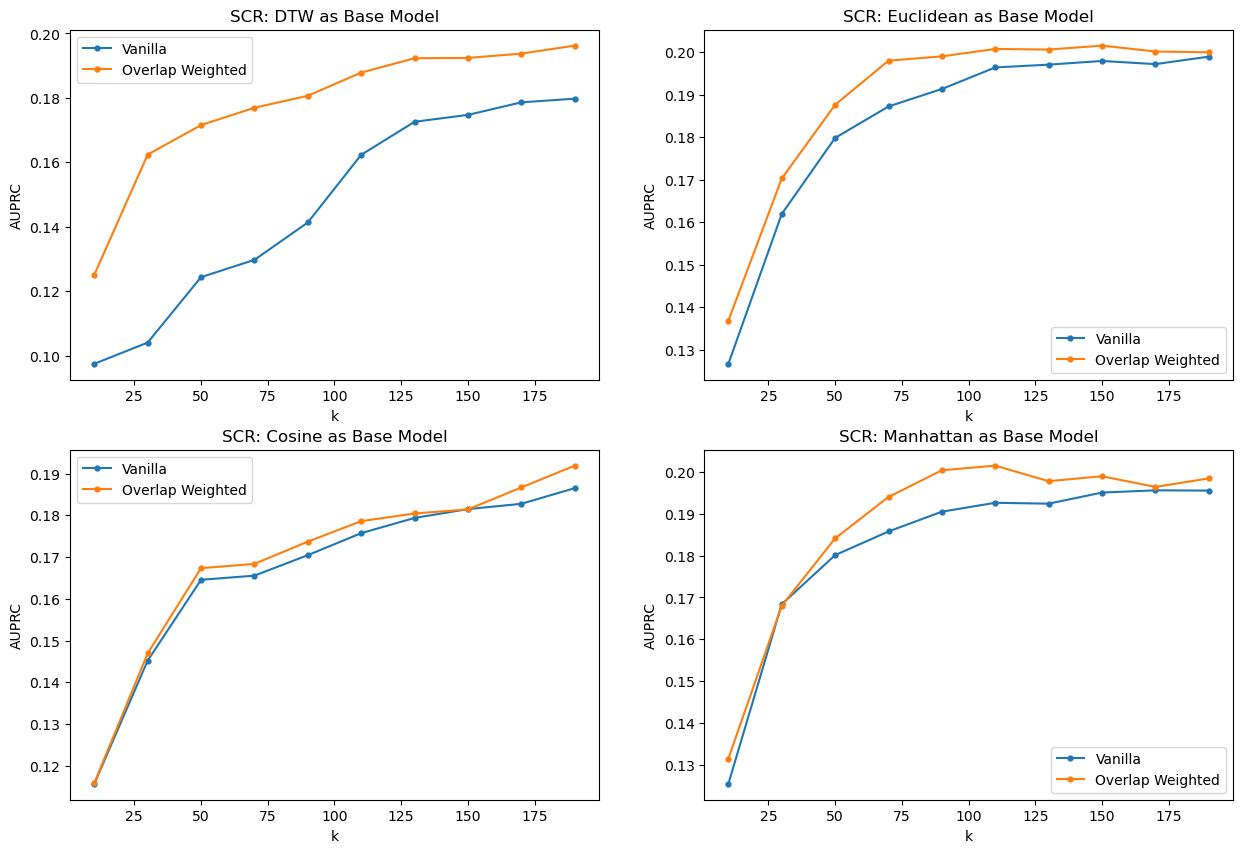

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUPRC"

plot_AUPRC_along_k(axs[0,0], 
                   k_sizes_test,
                   SCR_DTW_control["Vanilla"][metric], 
                   SCR_DTW_control["OW"][metric], 
                   "SCR: DTW as Base Model", metric)

plot_AUPRC_along_k(axs[0,1], 
                   k_sizes_test,
                   SCR_Euc_control["Vanilla"][metric], 
                   SCR_Euc_control["OW"][metric], 
                   "SCR: Euclidean as Base Model", metric)
plot_AUPRC_along_k(axs[1,0], 
                   k_sizes_test,
                   SCR_Cos_control["Vanilla"][metric], 
                   SCR_Cos_control["OW"][metric], 
                   "SCR: Cosine as Base Model", metric)
plot_AUPRC_along_k(axs[1,1], 
                   k_sizes_test,
                   SCR_Manh_control["Vanilla"][metric], 
                   SCR_Manh_control["OW"][metric], 
                   "SCR: Manhattan as Base Model", metric)

plt.show()

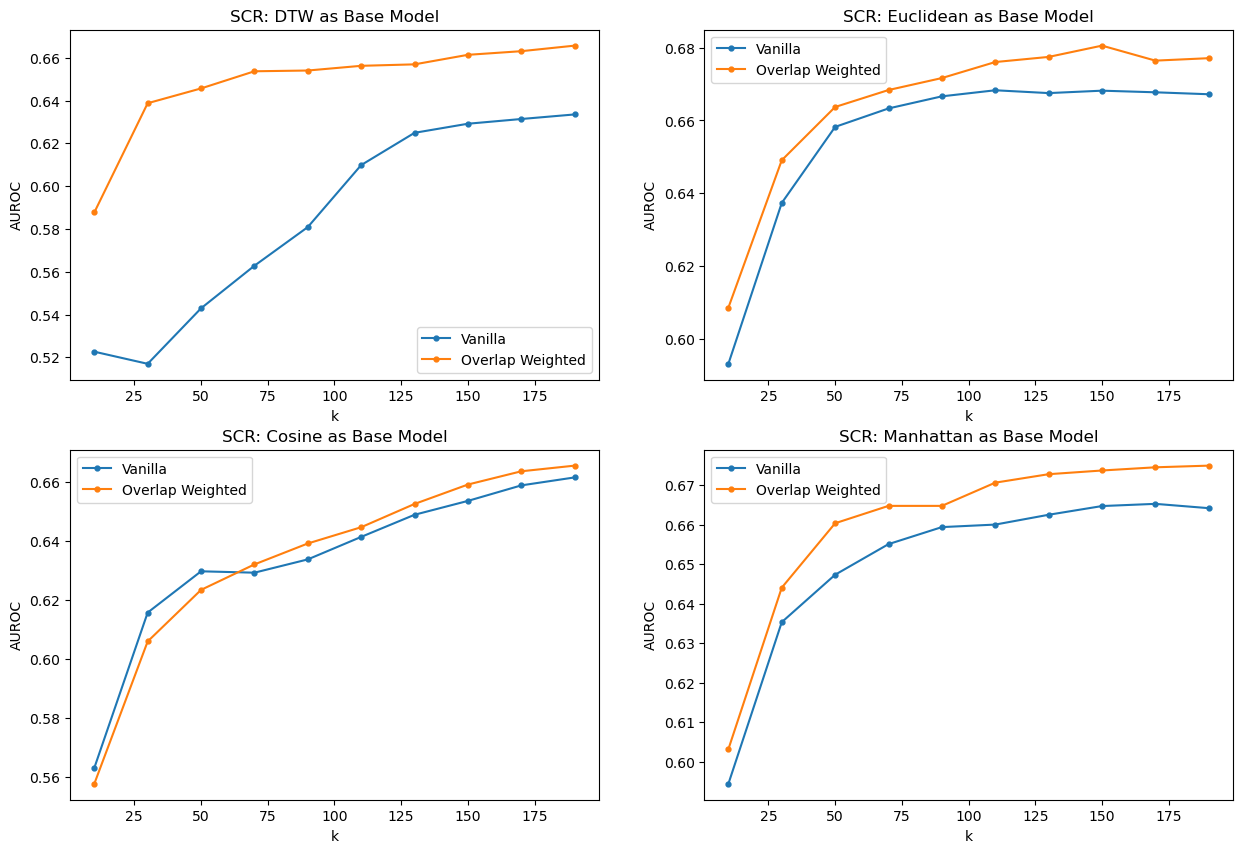

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUROC"

plot_AUPRC_along_k(axs[0,0], 
                   k_sizes_test,
                   SCR_DTW_control["Vanilla"][metric], 
                   SCR_DTW_control["OW"][metric], 
                   "SCR: DTW as Base Model", metric)

plot_AUPRC_along_k(axs[0,1], 
                   k_sizes_test,
                   SCR_Euc_control["Vanilla"][metric], 
                   SCR_Euc_control["OW"][metric], 
                   "SCR: Euclidean as Base Model", metric)
plot_AUPRC_along_k(axs[1,0], 
                   k_sizes_test,
                   SCR_Cos_control["Vanilla"][metric], 
                   SCR_Cos_control["OW"][metric], 
                   "SCR: Cosine as Base Model", metric)
plot_AUPRC_along_k(axs[1,1], 
                   k_sizes_test,
                   SCR_Manh_control["Vanilla"][metric], 
                   SCR_Manh_control["OW"][metric], 
                   "SCR: Manhattan as Base Model", metric)

plt.show()

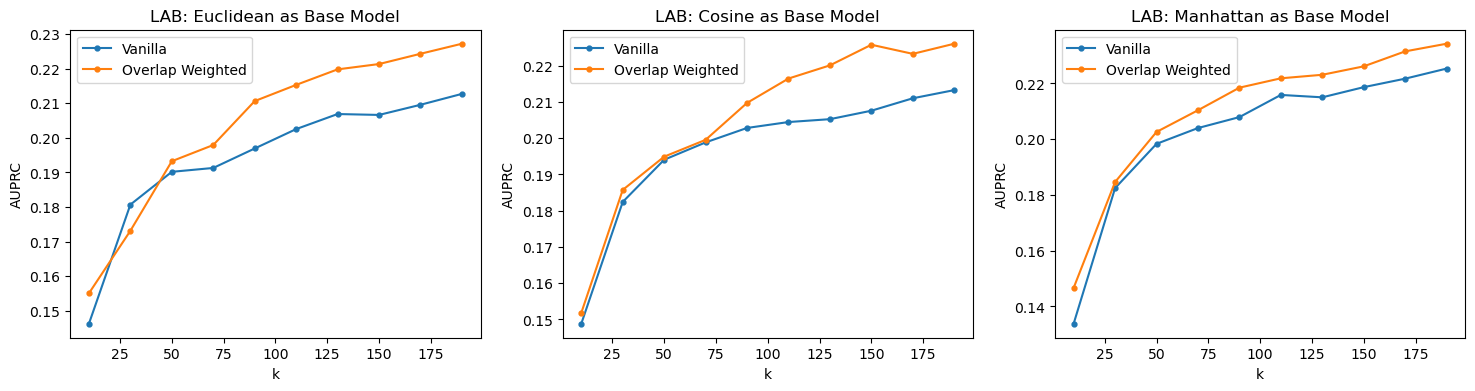

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUPRC"

plot_AUPRC_along_k(axs[0], 
                   k_sizes_test,
                   LAB_Euc_control["Vanilla"][metric], 
                   LAB_Euc_control["OW"][metric], 
                   "LAB: Euclidean as Base Model", metric)
plot_AUPRC_along_k(axs[1], 
                   k_sizes_test,
                   LAB_Cos_control["Vanilla"][metric], 
                   LAB_Cos_control["OW"][metric], 
                   "LAB: Cosine as Base Model", metric)
plot_AUPRC_along_k(axs[2], 
                   k_sizes_test,
                   LAB_Manh_control["Vanilla"][metric], 
                   LAB_Manh_control["OW"][metric], 
                   "LAB: Manhattan as Base Model", metric)

plt.show()

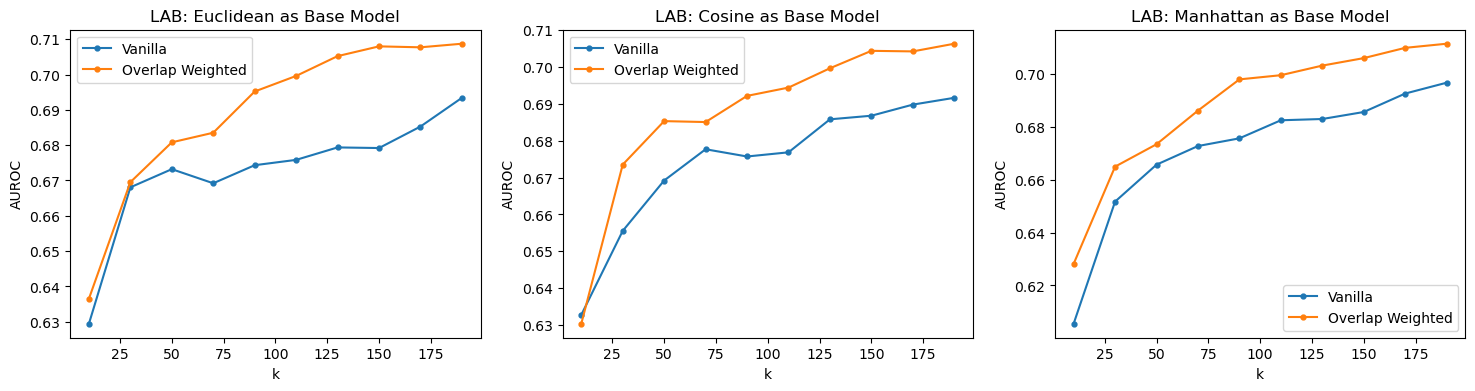

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUROC"

plot_AUPRC_along_k(axs[0], 
                   k_sizes_test,
                   LAB_Euc_control["Vanilla"][metric], 
                   LAB_Euc_control["OW"][metric], 
                   "LAB: Euclidean as Base Model", metric)
plot_AUPRC_along_k(axs[1], 
                   k_sizes_test,
                   LAB_Cos_control["Vanilla"][metric], 
                   LAB_Cos_control["OW"][metric], 
                   "LAB: Cosine as Base Model", metric)
plot_AUPRC_along_k(axs[2], 
                   k_sizes_test,
                   LAB_Manh_control["Vanilla"][metric], 
                   LAB_Manh_control["OW"][metric], 
                   "LAB: Manhattan as Base Model", metric)

plt.show()

# Proof: Searched Measure is Better Than Others

In [107]:
SCR_control_measure_names = ["DTW", "Euc", "Manh", "Cos"]

SCR_no_eva_controls = [SCR_DTW_control["Vanilla"]["AUPRC"], SCR_Euc_control["Vanilla"]["AUPRC"],
                       SCR_Manh_control["Vanilla"]["AUPRC"], SCR_Cos_control["Vanilla"]["AUPRC"]]
SCR_ow_eva_controls = [SCR_DTW_control["OW"]["AUPRC"], SCR_Euc_control["OW"]["AUPRC"],
                         SCR_Manh_control["OW"]["AUPRC"], SCR_Cos_control["OW"]["AUPRC"]]

In [108]:
def plot_control_vs_exp_performance(ax, k_sizes, feature_eva_controls, control_measure_names, best_measure_name, title):
    markersize = 7
    
    best_idx = control_measure_names.index(best_measure_name)
    
    candidate_control_linecolor = ['deepskyblue', 'dodgerblue', 'skyblue', 'steelblue', 
                                   'cornflowerblue', 'royalblue', 'mediumblue', 'slateblue', 'darkblue']
    for i in range(len(control_measure_names)):
        if i == best_idx:
            color = "red"
            alpha = 1.0
        else:
            color = candidate_control_linecolor[i]
            alpha = 0.3
        ax.plot(k_sizes, feature_eva_controls[i], label="Control - %s"%(control_measure_names[i]), 
                marker='.', markersize=markersize, color = color, alpha = alpha)
    
    ax.set_title(title)
    ax.set_xlabel('k')
    ax.set_ylabel('AUPRC')
    ax.legend()

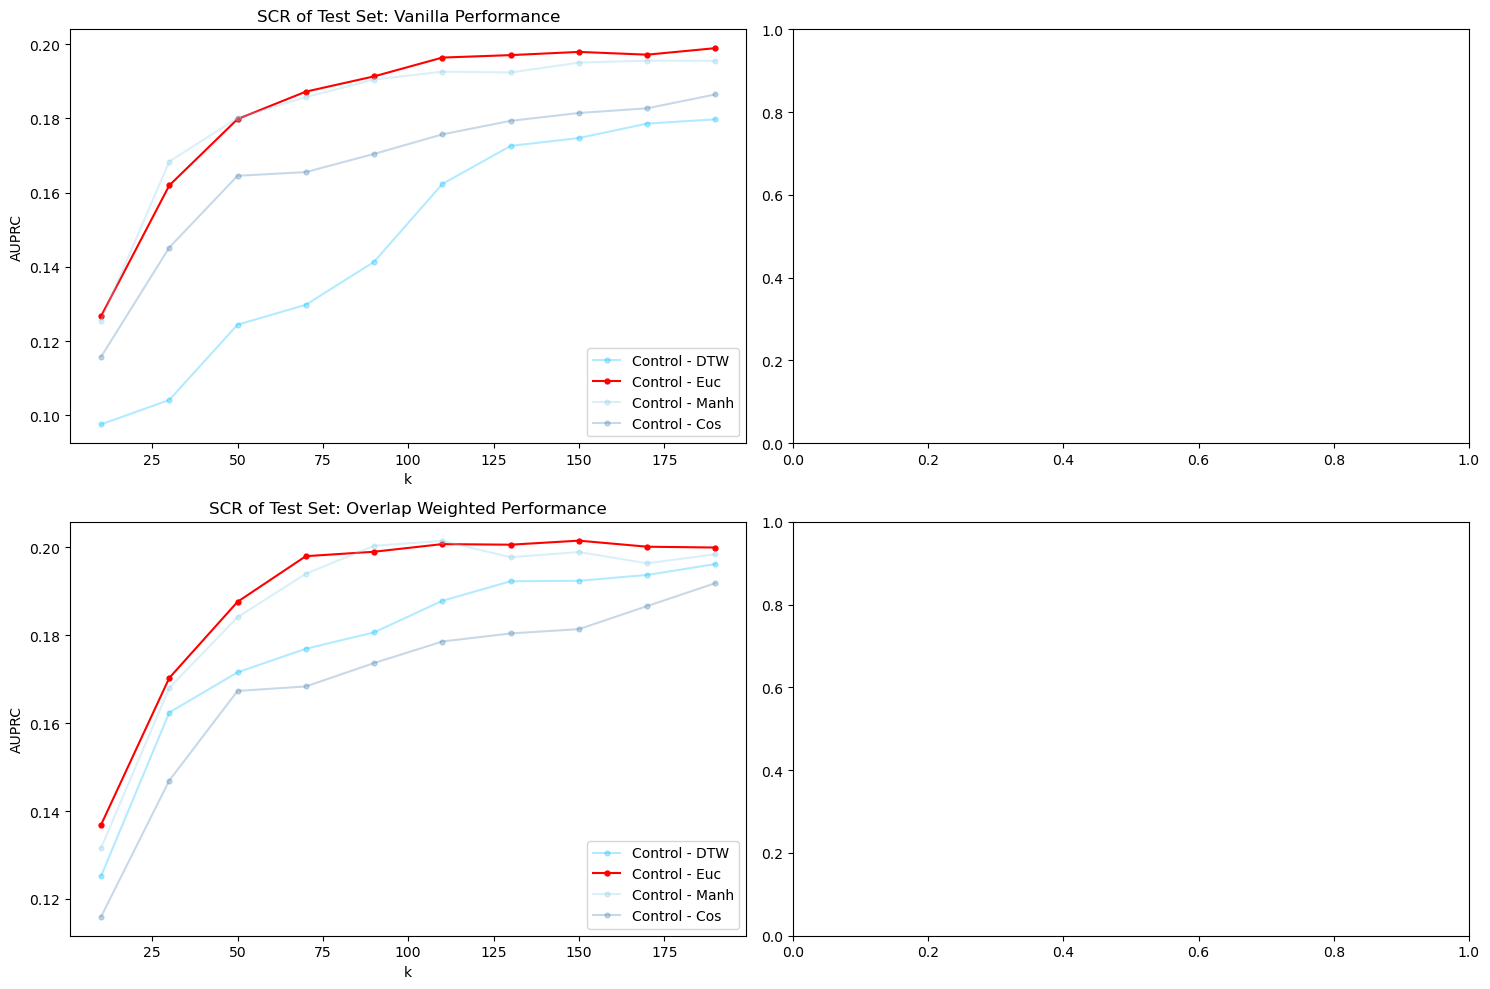

In [109]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots, adjust the figure size as needed

plot_control_vs_exp_performance(axs[0, 0], k_sizes_test, SCR_no_eva_controls, SCR_control_measure_names, 
                                best_method_each_condition["SCR Vanilla"], 'SCR of Test Set: Vanilla Performance')
plot_control_vs_exp_performance(axs[1, 0], k_sizes_test, SCR_ow_eva_controls, SCR_control_measure_names, 
                                best_method_each_condition["SCR OW"],'SCR of Test Set: Overlap Weighted Performance')

plt.tight_layout()
plt.show()

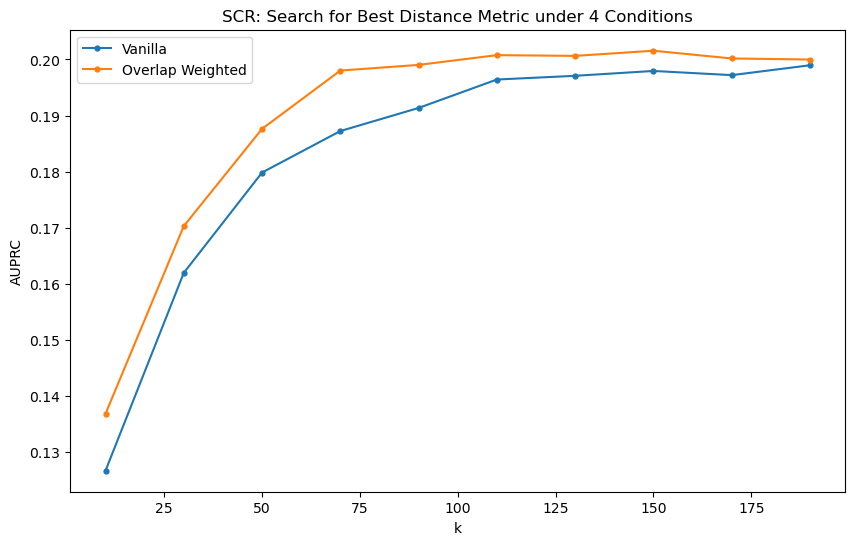

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(k_sizes_test, SCR_no_eva["AUPRC"], label = "Vanilla", marker='.', markersize=7)
plt.plot(k_sizes_test, SCR_ow_eva["AUPRC"], label = "Overlap Weighted", marker='.', markersize=7)
plt.title("SCR: Search for Best Distance Metric under 4 Conditions")
plt.ylabel('AUPRC')
plt.xlabel('k')
plt.legend()
plt.show()

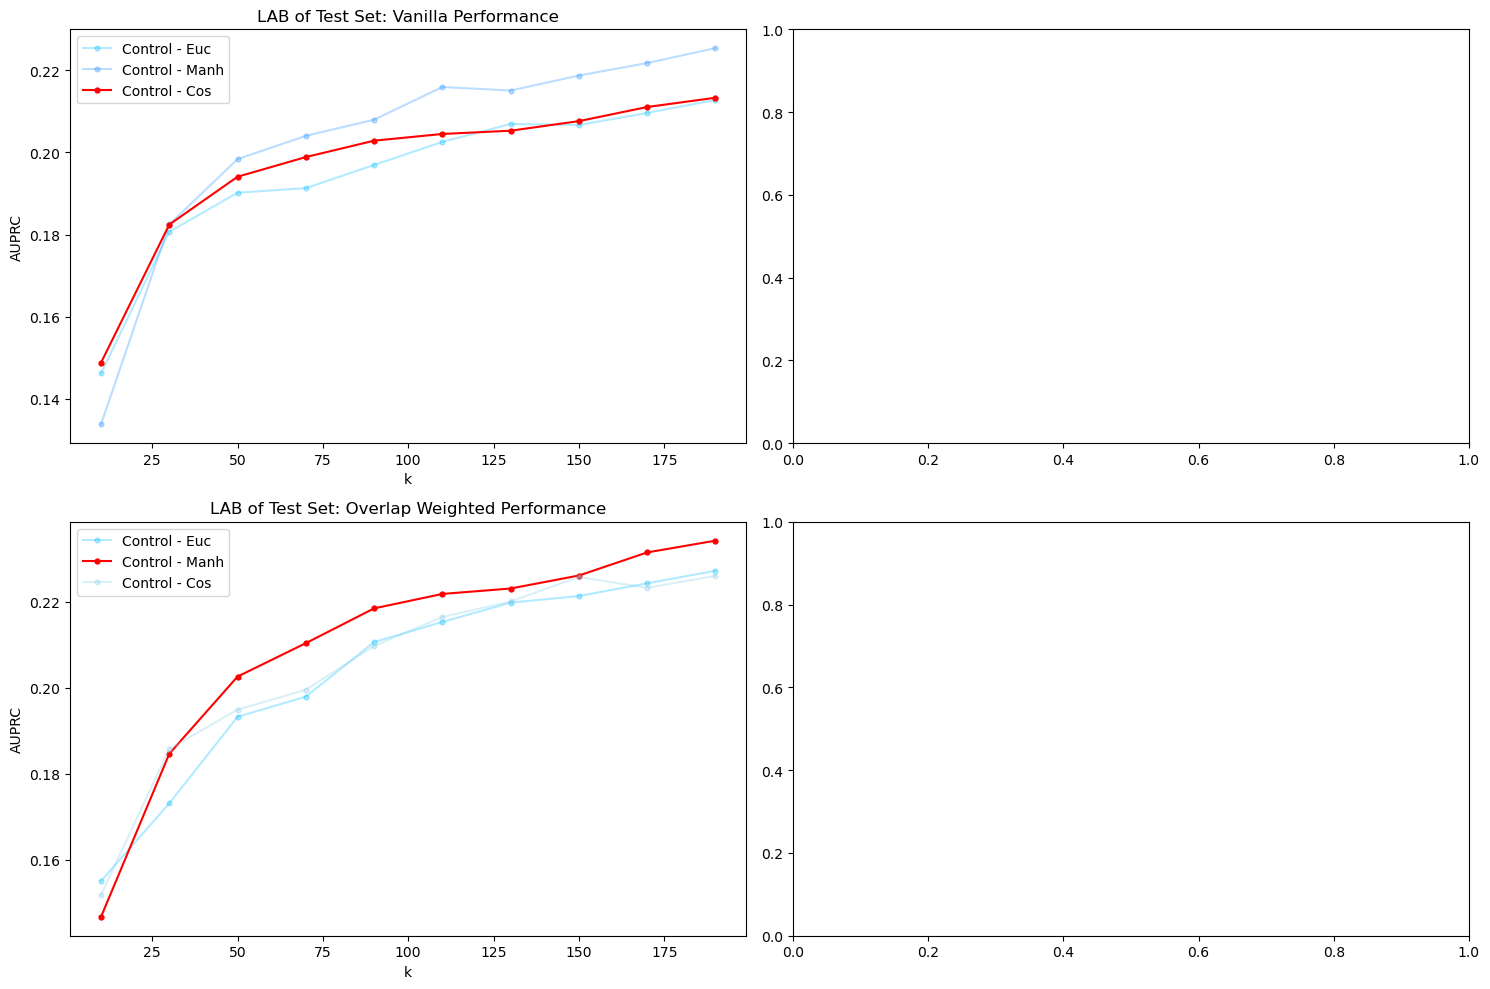

In [113]:
LAB_control_measure_names = ["Euc", "Manh", "Cos"]
LAB_no_eva_controls = [LAB_Euc_control["Vanilla"]["AUPRC"], LAB_Manh_control["Vanilla"]["AUPRC"], LAB_Cos_control["Vanilla"]["AUPRC"]]
LAB_ow_eva_controls = [LAB_Euc_control["OW"]["AUPRC"], LAB_Manh_control["OW"]["AUPRC"], LAB_Cos_control["OW"]["AUPRC"]]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots, adjust the figure size as needed

plot_control_vs_exp_performance(axs[0, 0], k_sizes_test, LAB_no_eva_controls, LAB_control_measure_names, 
                                best_method_each_condition["LAB Vanilla"], 'LAB of Test Set: Vanilla Performance')
plot_control_vs_exp_performance(axs[1, 0], k_sizes_test, LAB_ow_eva_controls, LAB_control_measure_names, 
                                best_method_each_condition["LAB OW"], 'LAB of Test Set: Overlap Weighted Performance')

plt.tight_layout()
plt.show()

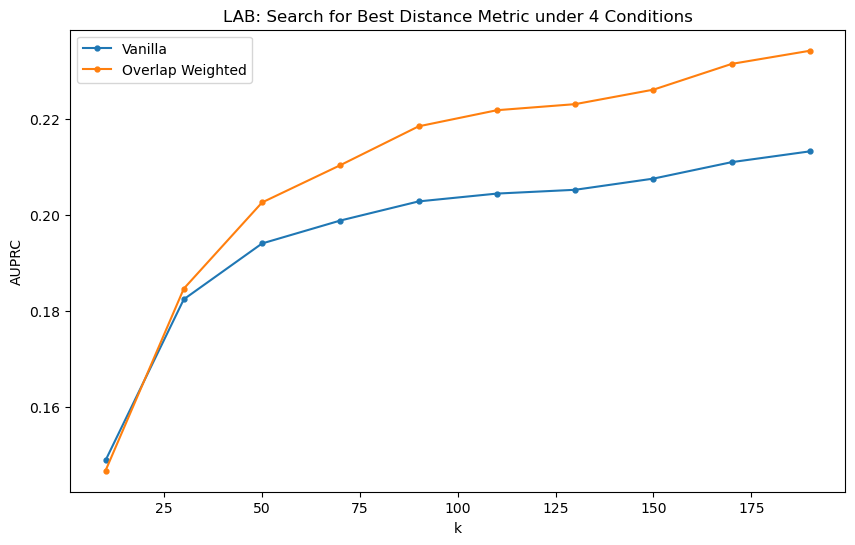

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(k_sizes_test, LAB_no_eva["AUPRC"], label = "Vanilla", marker='.', markersize=7)
plt.plot(k_sizes_test, LAB_ow_eva["AUPRC"], label = "Overlap Weighted", marker='.', markersize=7)
plt.title("LAB: Search for Best Distance Metric under 4 Conditions")
plt.ylabel('AUPRC')
plt.xlabel('k')
plt.legend()
plt.show()

# Search Weights to Combine Feature Types

In [115]:
# store all simi mtx for reference
# _w is for overlap weighting
# we cannot transform them into dict now because they need to be weighted sumed
# then they will be transformed into simi idx and then dict
all_simi_mtx_collection_train = dict()

all_simi_mtx_collection_train["SCR"] = dict()
all_simi_mtx_collection_train["LAB"] = dict()

all_simi_mtx_collection_train["SCR"]["DTW"] = SCR_DTW_simi_train
all_simi_mtx_collection_train["SCR"]["Euc"] = SCR_Euc_simi_train
all_simi_mtx_collection_train["SCR"]["Cos"] = SCR_Cos_simi_train
all_simi_mtx_collection_train["SCR"]["Manh"] = SCR_Manh_simi_train

all_simi_mtx_collection_train["LAB"]["Euc"] = LAB_Euc_simi_train
all_simi_mtx_collection_train["LAB"]["Manh"] = LAB_Manh_simi_train
all_simi_mtx_collection_train["LAB"]["Cos"] = LAB_Cos_simi_train

all_simi_w_mtx_collection_train = dict()

all_simi_w_mtx_collection_train["SCR"] = dict()
all_simi_w_mtx_collection_train["LAB"] = dict()

all_simi_w_mtx_collection_train["SCR"]["DTW"] = SCR_DTW_simi_w_train
all_simi_w_mtx_collection_train["SCR"]["Euc"] = SCR_Euc_simi_w_train
all_simi_w_mtx_collection_train["SCR"]["Cos"] = SCR_Cos_simi_w_train
all_simi_w_mtx_collection_train["SCR"]["Manh"] = SCR_Manh_simi_w_train

all_simi_w_mtx_collection_train["LAB"]["Euc"] = LAB_Euc_simi_w_train
all_simi_w_mtx_collection_train["LAB"]["Manh"] = LAB_Manh_simi_w_train
all_simi_w_mtx_collection_train["LAB"]["Cos"] = LAB_Cos_simi_w_train

In [116]:
# we do not need to pass all the mtx, just need the best method one
best_measure_simi_mtx_train = dict()
best_measure_simi_w_mtx_train = dict()

best_measure_simi_mtx_train["SCR"] = all_simi_mtx_collection_train["SCR"][best_method_each_condition["SCR Vanilla"]]
best_measure_simi_mtx_train["LAB"] = all_simi_mtx_collection_train["LAB"][best_method_each_condition["LAB Vanilla"]]

best_measure_simi_w_mtx_train["SCR"] = all_simi_w_mtx_collection_train["SCR"][best_method_each_condition["SCR OW"]]
best_measure_simi_w_mtx_train["LAB"] = all_simi_w_mtx_collection_train["LAB"][best_method_each_condition["LAB OW"]]

In [131]:
# get all possible weight combination
# A is for weighting SCR, B is for LAB
weight_combos = []
for A in np.arange(0.1, 1.1, 0.1):
    for B in np.arange(0.1, 1.1, 0.1):
        if A + B == 1:
            weight_combos.append((round(A, 1), round(B, 1)))  

In [132]:
# get how many combination of parameters in total
len(weight_combos)

9

In [119]:
%store weight_combos

Stored 'weight_combos' (list)


Weight Searching Main Function

In [124]:
from multiprocessing import Pool
from functools import partial

In [134]:
def search_combo_weights_parallel(num_processors):
    # Use Pool with imap_unordered and wrap with tqdm
    with Pool(num_processors) as pool:
        results = list(tqdm(pool.imap(process_for_single_k, k_sizes), 
                            total=len(k_sizes)))
    pool.close()
    pool.join()
    return results

In [135]:
# Worker function to handle all weight combinations for a single k
def process_for_single_k(k):
    # Get the best feature type similarity measures for the current k
    # Retrieve best similarity arrays
    SCR_best_simi_train = ref_simi_mtx_collection_train["SCR"]
    LAB_best_simi_train = ref_simi_mtx_collection_train["LAB"]
    
    assert(SCR_best_simi_train.shape[0] == LAB_best_simi_train.shape[0])

    best_AUPRC = 0
    best_weight_combo = None

    # Iterate over all weight combinations
    for (A, B) in weight_combos:
        
        # search is under no weighted voting KNN
        AUPRC, _ = combo_weights_evaluate_for_train(SCR_best_simi_train, LAB_best_simi_train, A, B, y_train, k)
        if AUPRC > best_AUPRC:
            best_AUPRC = AUPRC
            best_weight_combo = (A, B)

    return [k, best_AUPRC, best_weight_combo]

In [136]:
def combo_weights_evaluate_for_train(SCR_simi_train, LAB_simi_train, A, B, y_train, k):
    # weighted sum of the simi mtxs and min-max normalization 
    combined_simi_train = A * SCR_simi_train + B * LAB_simi_train
    combined_simi_train = min_max_normalization(combined_simi_train)
    # get the ordered idx
    combined_idx_train = slow_argsort(combined_simi_train)
    # organize the sorted idx into dict
    neighbor_idx, neighbor_y = process_similarity_arr_for_train(y_train, combined_idx_train)
    combined_dict = {"idx": neighbor_idx, "label": neighbor_y}
    
    #trainlute the KNN results
    AUPRC, AUROC = KNN(combined_dict, k, y_train)
    return AUPRC, AUROC

In [137]:
ref_simi_mtx_collection_train = best_measure_simi_mtx_train
weight_combos_results = search_combo_weights_parallel(num_processors)

100%|██████████| 39/39 [06:06<00:00,  9.40s/it]  


In [138]:
ref_simi_mtx_collection_train = best_measure_simi_w_mtx_train
weight_combos_w_results = search_combo_weights_parallel(num_processors)

100%|██████████| 39/39 [05:44<00:00,  8.84s/it]  


# Add Weight Combo Results to Grid Search Table

In [139]:
grid_search_table["ALL Vanilla"] = [info[2] for info in weight_combos_results]
grid_search_table["ALL OW"] = [info[2] for info in weight_combos_w_results]

In [140]:
grid_search_table

,SCR Vanilla,LAB Vanilla,SCR OW,LAB OW,ALL Vanilla,ALL OW
k,,,,,,
10,Manh,Euc,DTW,Euc,"(0.6, 0.4)","(0.5, 0.5)"
15,Euc,Cos,DTW,Euc,"(0.8, 0.2)","(0.8, 0.2)"
20,Euc,Cos,DTW,Euc,"(0.8, 0.2)","(0.8, 0.2)"
25,Euc,Cos,DTW,Cos,"(0.9, 0.1)","(0.7, 0.3)"
30,Euc,Cos,DTW,Euc,"(0.2, 0.8)","(0.8, 0.2)"
35,Euc,Cos,DTW,Euc,"(0.2, 0.8)","(0.7, 0.3)"
40,Euc,Cos,DTW,Euc,"(0.1, 0.9)","(0.7, 0.3)"
45,Euc,Cos,DTW,Euc,"(0.1, 0.9)","(0.5, 0.5)"
50,Euc,Cos,Euc,Euc,"(0.2, 0.8)","(0.7, 0.3)"


In [141]:
grid_search_table.to_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput2.csv",
                        index = True)

In [142]:
grid_search_table = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput2.csv",
                               index_col = 0)

# Apply Searched Weights and Metrics to Test set

In [143]:
all_simi_mtx_collection = dict()

all_simi_mtx_collection["SCR"] = dict()
all_simi_mtx_collection["LAB"] = dict()

all_simi_mtx_collection["SCR"]["DTW"] = SCR_DTW_simi
all_simi_mtx_collection["SCR"]["Euc"] = SCR_Euc_simi
all_simi_mtx_collection["SCR"]["Cos"] = SCR_Cos_simi
all_simi_mtx_collection["SCR"]["Manh"] = SCR_Manh_simi


all_simi_mtx_collection["LAB"]["Euc"] = LAB_Euc_simi
all_simi_mtx_collection["LAB"]["Manh"] = LAB_Manh_simi
all_simi_mtx_collection["LAB"]["Cos"] = LAB_Cos_simi

all_simi_w_mtx_collection = dict()

all_simi_w_mtx_collection["SCR"] = dict()
all_simi_w_mtx_collection["LAB"] = dict()

all_simi_w_mtx_collection["SCR"]["DTW"] = SCR_DTW_simi_w
all_simi_w_mtx_collection["SCR"]["Euc"] = SCR_Euc_simi_w
all_simi_w_mtx_collection["SCR"]["Cos"] = SCR_Cos_simi_w
all_simi_w_mtx_collection["SCR"]["Manh"] = SCR_Manh_simi_w

all_simi_w_mtx_collection["LAB"]["Euc"] = LAB_Euc_simi_w
all_simi_w_mtx_collection["LAB"]["Manh"] = LAB_Manh_simi_w
all_simi_w_mtx_collection["LAB"]["Cos"] = LAB_Cos_simi_w

In [144]:
# we do not need to pass all the mtx, just need the best method one
best_measure_simi_mtx = dict()
best_measure_simi_w_mtx = dict()

best_measure_simi_mtx["SCR"] = all_simi_mtx_collection["SCR"][best_method_each_condition["SCR Vanilla"]]
best_measure_simi_mtx["LAB"] = all_simi_mtx_collection["LAB"][best_method_each_condition["LAB Vanilla"]]

best_measure_simi_w_mtx["SCR"] = all_simi_w_mtx_collection["SCR"][best_method_each_condition["SCR OW"]]
best_measure_simi_w_mtx["LAB"] = all_simi_w_mtx_collection["LAB"][best_method_each_condition["LAB OW"]]

In [153]:
X_train_glob = pd.concat([SCR_train, LAB_train], axis = 1)
X_test_glob = pd.concat([SCR_test, LAB_test], axis = 1)

In [155]:
def test_final_personalized_model(X_train_glob, X_test_glob, k_sizes, use_overlap_weighting, grid_search_table, train_idx, test_idx, 
                                  y, y_test, best_measure_simi_mtx):
    results = dict()
    results["AUPRC"] = []
    results["AUROC"] = []
        
    # get the corresponding simi mtx
    SCR_best_simi = best_measure_simi_mtx["SCR"]
    LAB_best_simi = best_measure_simi_mtx["LAB"]
    
    for k in tqdm(k_sizes):
        
        best_weight_combo = eval(query_grid_search_table_for_weights(grid_search_table, k, use_overlap_weighting))
        
        A = best_weight_combo[0]
        B = best_weight_combo[1]
        
        combined_dict = combo_weights_evaluate_for_test(SCR_best_simi, LAB_best_simi, A, B, train_idx, test_idx, y)
        
        full_AUPRC, full_AUROC = predict_by_LR(X_train_glob, X_test_glob, combined_dict, k, y_test)
        
        
        results["AUPRC"].append(full_AUPRC)
        results["AUROC"].append(full_AUROC)
        
    return results

In [156]:
def combo_weights_evaluate_for_test(SCR_simi, LAB_simi, A, B, train_idx, test_idx, y):
    # weighted sum of the simi mtxs and min-max normalization 
    combined_simi = A * SCR_simi + B * LAB_simi
    combined_simi = min_max_normalization(combined_simi)
    # get the ordered idx
    combined_idx = slow_argsort(combined_simi)
    # organize the sorted idx into dict
    neighbor_idx, neighbor_y = process_similarity_arr_for_test(train_idx, test_idx, combined_idx, y)
    combined_dict = {"idx": neighbor_idx, "label": neighbor_y}
    return combined_dict

In [157]:
def query_grid_search_table_for_weights(grid_search_table, k, use_overlap_weighting):
    if not use_overlap_weighting:
        return grid_search_table.loc[k, "ALL Vanilla"]
    elif use_overlap_weighting:
        return grid_search_table.loc[k, "ALL OW"]

In [158]:
y = np.array(dataset["AKI_LABEL"])

In [160]:
final_performance_no = test_final_personalized_model(X_train_glob, X_test_glob, k_sizes_test, False, grid_search_table, 
                                                     train_idx, test_idx, y, y_test, best_measure_simi_mtx)

100%|██████████| 10/10 [09:15<00:00, 55.55s/it]


In [161]:
with open('./Results_dict/Imputation_2/final_performance_no.json', 'w') as file:
    json.dump(final_performance_no, file)

In [ ]:
# read performance results
final_performance_no = json.load(open('./Results_dict/Imputation_2/final_performance_no.json', 'r'))

In [162]:
final_performance_ow = test_final_personalized_model(X_train_glob, X_test_glob, k_sizes_test, True, grid_search_table, 
                                                     train_idx, test_idx, y, y_test, best_measure_simi_w_mtx)

100%|██████████| 10/10 [09:07<00:00, 54.75s/it]


In [163]:
with open('./Results_dict/Imputation_2/final_performance_ow.json', 'w') as file:
    json.dump(final_performance_ow, file)

In [ ]:
# read performance results
final_performance_ow = json.load(open('./Results_dict/Imputation_2/final_performance_ow.json', 'r'))

In [ ]:
def get_weight_control_performance(X_train_glob, X_test_glob, k_sizes, weight_combos, train_idx, test_idx, y, y_test, best_measure_simi_mtx):
    results = dict()
    
    # get the corresponding simi mtx
    SCR_best_simi = best_measure_simi_mtx["SCR"] 
    LAB_best_simi = best_measure_simi_mtx["LAB"]
    
    for (A, B) in (weight_combos):
        
        results[str((A, B))] = dict()
        results[str((A, B))]["AUPRC"] = []
        results[str((A, B))]["AUROC"] = []
        
        combined_dict = combo_weights_evaluate_for_test(SCR_best_simi, LAB_best_simi, A, B, train_idx, test_idx, y) 
        for k in tqdm(k_sizes):
            
            full_AUPRC, full_AUROC = predict_by_LR(X_train_glob, X_test_glob, combined_dict, k, y_test)
            
        
            results[str((A, B))]["AUPRC"].append(full_AUPRC)
            results[str((A, B))]["AUROC"].append(full_AUROC)
        
    return results

In [ ]:
weight_control_performance_no = get_weight_control_performance(X_train_glob, X_test_glob, k_sizes_test, weight_combos, 
                                                               train_idx, test_idx, y, y_test, best_measure_simi_mtx)

In [ ]:
with open('./Results_dict/Imputation_2/weight_control_performance_no.json', 'w') as file:
    json.dump(weight_control_performance_no, file)

In [ ]:
# read performance results
weight_control_performance_no = json.load(open('./Results_dict/Imputation_2/weight_control_performance_no.json', 'r'))

In [ ]:
weight_control_performance_ow = get_weight_control_performance(X_train_glob, X_test_glob, k_sizes_test, weight_combos, 
                                                               train_idx, test_idx, y, y_test, best_measure_simi_w_mtx)

In [ ]:
with open('./Results_dict/Imputation_2/weight_control_performance_ow.json', 'w') as file:
    json.dump(weight_control_performance_ow, file)

In [ ]:
# read performance results
weight_control_performance_ow = json.load(open('./Results_dict/Imputation_2/weight_control_performance_ow.json', 'r'))

In [ ]:
def plot_weight_combo_control_performance(ax, k_sizes, weight_control_performance, final_performance, title):
    
    candidate_control_linecolor = ['lightblue', 'skyblue', 'deepskyblue', 
                                   'dodgerblue', 'cornflowerblue', 'royalblue', 
                                   'steelblue', 'mediumblue', 'darkblue', 'navy', 
                                   'midnightblue', 'slateblue', 'powderblue', 'cadetblue']
    
    for i, control_performance in enumerate(weight_control_performance.values()):
        if i == 0:
            label = "Fixed Weights"
        else:
            label = ""
            
        ax.plot(k_sizes, control_performance["AUPRC"], alpha = 0.25, marker='.', 
                markersize=10, color = candidate_control_linecolor[i], label = label)
        
    ax.plot(k_sizes, final_performance["AUPRC"], color = "red", alpha = 1,
            label = "Grid Searched Weights", marker='.', markersize=7)
        
    ax.set_title(title)
    ax.set_xlabel('k')
    ax.set_ylabel('AUPRC')
    ax.legend()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots, adjust the figure size as needed

plot_weight_combo_control_performance(axs[0, 0], k_sizes_test, weight_control_performance_no, 
                                      final_performance_no, "Vanilla Performance")
plot_weight_combo_control_performance(axs[1, 0], k_sizes_test, weight_control_performance_ow, 
                                      final_performance_ow, "Overlap Weighted Performance")

plt.tight_layout()
plt.show()

# Train a Global KNN

In [164]:
from sklearn.neighbors import KNeighborsClassifier

In [165]:
glob_KNN_Euc_performance = dict()
glob_KNN_Euc_performance["AUPRC"] = []
glob_KNN_Euc_performance["AUROC"] = []

for k in tqdm(k_sizes_test):
    knn = KNeighborsClassifier(n_neighbors=k, p = 2)
    knn.fit(X_train_glob, y_train)
    y_probs = knn.predict_proba(X_test_glob)[:, 1]
    y_preds = knn.predict(X_test_glob)
    
    AUPRC_glob = average_precision_score(y_test, y_probs)
    AUROC_glob = roc_auc_score(y_test, y_probs)
    
    glob_KNN_Euc_performance["AUPRC"].append(AUPRC_glob)
    glob_KNN_Euc_performance["AUROC"].append(AUROC_glob)

100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


In [ ]:
with open('./Results_dict/Imputation_2/glob_KNN_Euc_performance.json', 'w') as file:
    json.dump(glob_KNN_Euc_performance, file)

In [ ]:
# read performance results
glob_KNN_Euc_performance = json.load(open('./Results_dict/Imputation_2/glob_KNN_Euc_performance.json', 'r'))

# Train a Global Personalized LR

In [172]:
X_full_glob = pd.concat([X_train_glob, X_test_glob], axis = 0)

In [233]:
FULL_Euc_dist = pairwise_distances(X_full_glob, metric='euclidean', n_jobs=-1)
FULL_Euc_simi = translate_dist_mtx_to_simi(FULL_Euc_dist)
FULL_Euc_idx = fast_argsort(FULL_Euc_simi, num_processors)

In [235]:
FULL_Euc_idx_eva_clean, FULL_Euc_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, FULL_Euc_idx, y)

In [189]:
# Shuffle each row with the same order
FULL_Euc_idx_eva_shuflled = np.empty_like(FULL_Euc_idx_eva_clean)
FULL_Euc_y_eva_shuflled = np.empty_like(FULL_Euc_y_eva_clean)

for i in range(FULL_Euc_idx_eva_clean.shape[0]):
    # Generate a random permutation of indices for the row
    indices = np.random.permutation(FULL_Euc_idx_eva_clean.shape[1])
    # Shuffle rows of both arrays using the same order
    FULL_Euc_idx_eva_shuflled[i] = FULL_Euc_idx_eva_clean[i, indices]
    FULL_Euc_y_eva_shuflled[i] = FULL_Euc_y_eva_clean[i, indices]

In [ ]:
FULL_simi_dict_collection_eva = {"Euc": {"idx": FULL_Euc_idx_eva_clean, "label": FULL_Euc_y_eva_clean},
                                 "Random": {"idx": FULL_Euc_idx_eva_shuflled, "label": FULL_Euc_y_eva_shuflled}}

In [ ]:
global_LR_Euc_performance = {"AUPRC": [], "AUROC": []}
global_LR_random_performance = {"AUPRC": [], "AUROC": []}
for k in tqdm(k_sizes_test):
    global_LR_Euc_AUPRC, global_LR_Euc_AUROC = predict_by_LR(X_train_glob, X_test_glob, FULL_simi_dict_collection_eva['Euc'], k, y_test)
    global_LR_Euc_performance["AUPRC"].append(global_LR_Euc_AUPRC)
    global_LR_Euc_performance["AUROC"].append(global_LR_Euc_AUROC)
    global_LR_rand_AUPRC, global_LR_rand_AUROC = predict_by_LR(X_train_glob, X_test_glob, FULL_simi_dict_collection_eva['Random'], k, y_test)
    global_LR_random_performance["AUPRC"].append(global_LR_rand_AUPRC)
    global_LR_random_performance["AUROC"].append(global_LR_rand_AUROC)

100%|██████████| 10/10 [03:32<00:00, 21.29s/it]


In [ ]:
with open('./Results_dict/Imputation_2/global_LR_Euc_performance.json', 'w') as file:
    json.dump(global_LR_Euc_performance, file)
with open('./Results_dict/Imputation_2/global_LR_random_performance.json', 'w') as file:
    json.dump(global_LR_random_performance, file)

In [ ]:
# read performance results
global_LR_Euc_performance = json.load(open('./Results_dict/Imputation_2/global_LR_Euc_performance.json', 'r'))
global_LR_random_performance = json.load(open('./Results_dict/Imputation_2/global_LR_random_performance.json', 'r'))

# Plot the Performance

In [254]:
def plot_final_performance_metrics(ax, k_sizes, metric, final_performance_no, final_performance_ow, global_LR_Euc_performance, 
                                   global_LR_random_performance, glob_KNN_Euc_performance):
    ax.plot(k_sizes, final_performance_ow[metric], label = "Personalized LR (optimizing + weighting)", marker='.', markersize=7, color = "red")
    ax.plot(k_sizes, final_performance_no[metric], label = "Personalized LR (optimizing)", marker='.', markersize=7, color = "blue")
    ax.plot(k_sizes, global_LR_Euc_performance[metric], label = "Personalized LR (Euclidean)", marker='.', markersize=7, color = "green")
    ax.plot(k_sizes, global_LR_random_performance[metric], label = "Personalized LR (random)", marker='.', markersize=7, color = "orange")
    ax.plot(k_sizes, glob_KNN_Euc_performance[metric], label = "KNN", marker='.', markersize=7, color = "purple")
    ax.set_title(metric + ": All Feature Performance on Test Set")
    ax.set_ylabel(metric)
    ax.set_xlabel('k')
    ax.legend()

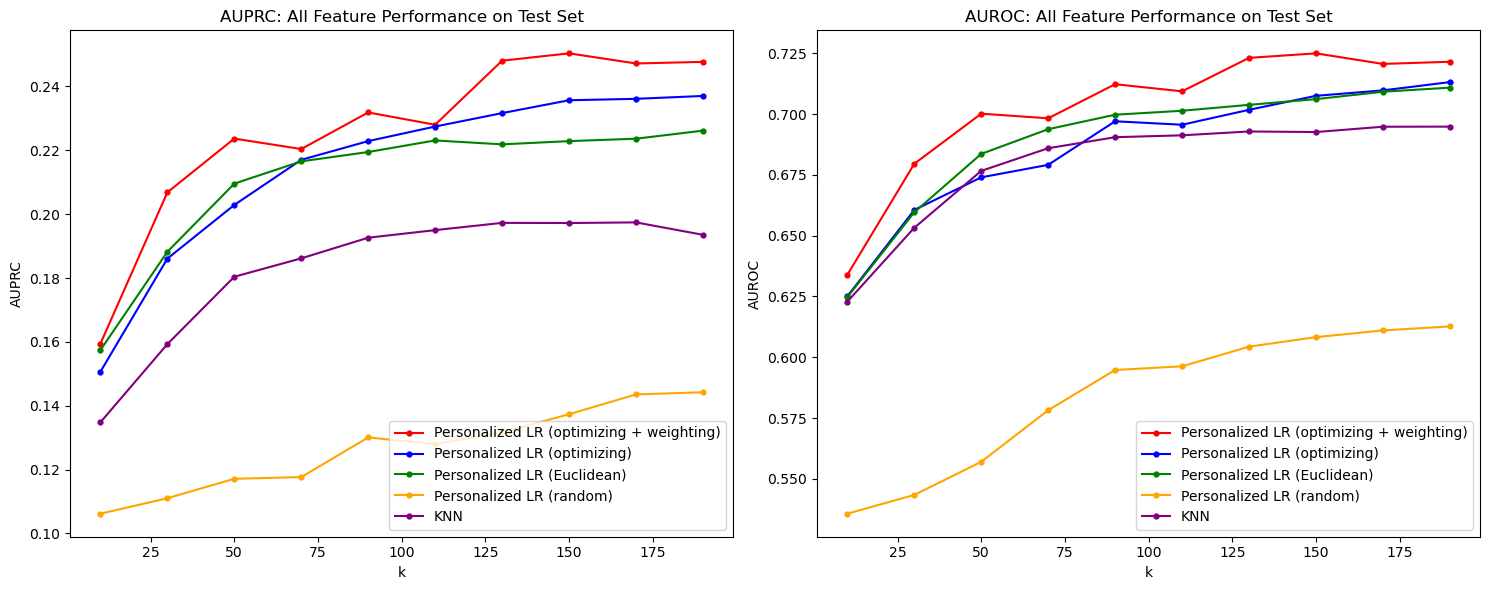

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 2x2 grid of subplots, adjust the figure size as needed

plot_final_performance_metrics(axs[0], k_sizes_test, "AUPRC", final_performance_no, final_performance_ow, global_LR_Euc_performance,
                               global_LR_random_performance, glob_KNN_Euc_performance)
plot_final_performance_metrics(axs[1], k_sizes_test, "AUROC", final_performance_no, final_performance_ow, global_LR_Euc_performance,
                               global_LR_random_performance, glob_KNN_Euc_performance)

plt.tight_layout()
plt.show()